HAM10000 images and metadata: https://drive.google.com/file/d/1h91HNUN5UBE6CexoxI_eXIb-KSDZk85m/view?usp=sharing


Extra Data from ISIC: https://drive.google.com/drive/folders/1glf4cqr_cMDYQ1jIEMBefnVsEam8gFLc?usp=sharing


All data pickled (use to avoid loading dataframe from scratch): https://drive.google.com/file/d/1pNXrwJNif_1hpZN5Xna4q0_sFFFGFo_T/view?usp=sharing

In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D,MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D,BatchNormalization
from keras.models import Model
from keras.layers import Input
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from matplotlib.pyplot import imshow
from sklearn.metrics import confusion_matrix, classification_report,roc_curve,auc,roc_auc_score,fbeta_score
import itertools
from keras import backend as K
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from livelossplot import PlotLossesKeras
import keras
#from keras.applications import InceptionV3, MobileNet
from keras.models import load_model
from keras.optimizers import Adam
import keras_metrics as km
from keras.callbacks import ModelCheckpoint, Callback
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from IPython.display import Audio
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE,RandomOverSampler
from keras import applications



Using TensorFlow backend.


### Loading and Pre-Processing Data

In [2]:
# set our input dimensions - can be changed later. Max this computer can handle is 200x200 @ 16GB Ram. More RAM = larger image size. 
input_dims = (200,200)

#set directory of images
impath = r'C:\Users\Admin\Downloads\skin-cancer-mnist-ham100002'

This function will set up a some dictionaries and add the info to the metadata csv accompanying the images. Details in comments below:

In [3]:
def create_df(path,input_dims):
    
    # create a dictionary of key: image ID and value: path to image
    imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(impath, '*.jpg'))}

    # Create a dctionary of labels used for mapping later - 1 for melanoma, 0 for everything else
    lesion_class_dict = {
        'nv': '0',
        'mel': '1',
        'bkl': '0',
        'bcc': '0',
        'akiec': '0',
        'vasc': '0',
        'df': '0'
    }
    
    # create a another dictionary for mapping of dataset names and corresponding full names from HAM1000 paper
    lesion_name_dict = {
        'nv': 'Melanocytic nevi',
        'mel': 'Melanoma',
        'bkl': 'Benign keratosis-like lesions ',
        'bcc': 'Basal cell carcinoma',
        'akiec': 'Actinic keratoses',
        'vasc': 'Vascular lesions',
        'df': 'Dermatofibroma'
    }
    
    # Read in the metadata csv HAM10000
    df = pd.read_csv(os.path.join(path, 'HAM10000_metadata.csv'))
    
    
    # Create some new columns in the metadata using the dictionaries above: path to image on disk, class of lesion, and lesion name
    df['path'] = df['image_id'].map(imageid_path_dict.get)
    df['class'] = df['dx'].map(lesion_class_dict.get) 
    df['lesion_name'] = df['dx'].map(lesion_name_dict.get)
    

    # loading image arrays into newly created 'image' column

    df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize(input_dims)))
    
    
    # =============================================================================
    #     NEW IMAGE DATA - 500 EXTRA MELANOMA
    # =============================================================================
    
    # directory of new images from ISIC
    newdir = r'C:\Users\Admin\Downloads\Extra Melanoma\Selection'
    
    # get list of images in dir
    new_im_list = os.listdir(r'C:\Users\Admin\Downloads\Extra Melanoma\Selection')
    
    # lisht
    new_ims=[]
    
    # resize to input dims and append
    for f in new_im_list:
        x = np.asarray(Image.open(os.path.join(newdir,f)).resize(input_dims))
        new_ims.append(x)
    
    # convert to df
    z = pd.DataFrame({'image':new_ims})
    
    # they're all melanoma = class 1
    z['class']='1'
    
    # concat two dfs 
    df=pd.concat([df,z],sort=True)
    
    df = df[['image','class']]
    
    return df

Now that the function is set up we can load and map all data including images to the metadata CSV. This loads and resizes over 10,000 images - takes about 2 minutes.

#### Note: dataframe was saved as pickle to avoid having to re-load images each training run. Just use read in pickle from now on. 

In [4]:
# original data loading function

#df = create_df(impath,input_dims)

# code below to save and load pickled dataframes - saves time 

# saves the df to pickle
#df.to_pickle(r'C:\Users\Admin\OneDrive - mycit.ie\Documents\CIT\Semester 2\Final Project\PW Submission 1\200_200_new_ims.pkl')

# read in the pickle
df=pd.read_pickle(r'C:\Users\Admin\OneDrive - mycit.ie\Documents\CIT\Semester 2\Final Project\PW Submission 1\200_200_new_ims.pkl')

Next step is to create a train test split function. 

In [5]:
def train_test_strat(df): # stratified split - not much difference
    
    x_train, x_test, y_train, y_test = train_test_split(df['image'], df['class'], test_size=0.2,random_state=5,stratify=df['class'])


    #what's the training set split like? IMBALANCED
    
    print('Training set balance:\n',y_train.value_counts())
    print('Test set balance:\n',y_test.value_counts())
    
    
    x_train = np.asarray(x_train.tolist())
    x_test = np.asarray(x_test.tolist())
    y_train = np.asarray(y_train.tolist(),dtype=np.uint8)
    y_test = np.asarray(y_test.tolist(),dtype=np.uint8)   
    
    
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    return x_train, x_test, y_train, y_test

In [6]:
def train_test(df): # Regular train test split
    
    x_train, x_test, y_train, y_test = train_test_split(df['image'], df['class'], test_size=0.2,random_state=5)


    #what's the training set split like? IMBALANCED
    
    print('Training set balance:\n',y_train.value_counts())
    print('Test set balance:\n',y_test.value_counts())
    
    
    x_train = np.asarray(x_train.tolist())
    x_test = np.asarray(x_test.tolist())
    y_train = np.asarray(y_train.tolist(),dtype=np.uint8)
    y_test = np.asarray(y_test.tolist(),dtype=np.uint8)   
    
    
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    return x_train, x_test, y_train, y_test

In [7]:
def train_test_val(df): # creates a train test val split. 
    
    x, x_test, y, y_test = train_test_split(df['image'], df['class'],test_size=0.2,train_size=0.8,random_state=5,stratify=df['class'])
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.25,train_size =0.75,random_state=5)
    #what's the training set split like? IMBALANCED
    
    print('Training set balance:\n',y_train.value_counts())
    print('Test set balance:\n',y_test.value_counts())
    print('Val set balance:\n',y_val.value_counts())
    
    x_train = np.asarray(x_train.tolist())
    x_test = np.asarray(x_test.tolist())
    x_val = np.asarray(x_val.tolist())
    y_train = np.asarray(y_train.tolist(),dtype=np.uint8)
    y_test = np.asarray(y_test.tolist(),dtype=np.uint8)   
    y_val = np.asarray(y_val.tolist(),dtype=np.uint8)  
    
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_val = x_test.astype('float32')
    
    return x_train, x_test, x_val, y_train, y_test, y_val

Now set up three types of normalizing functions to test - zscore, maxmin and dividing by total number of pixels

In [8]:
def norm_z(xtrain,xtest):
    
    # standardizes image arrays by subtracting mean and dividing by std dev
    x = (xtrain - xtrain.mean())/xtrain.std()
    y = (xtest - xtrain.mean())/xtrain.std()
    
    return x,y

def norm_maxmin(xtrain,xtest):
    x = (xtrain-np.min(xtrain))/(np.max(xtrain)-np.min(xtrain))
    y = (xtest-np.min(xtrain))/(np.max(xtrain)-np.min(xtrain))

    return x,y
    
def norm_255(xtrain,xtest):
    x = xtrain/255.0
    y = xtest/255.0
    
    return x,y   

### Model Creation Function

In [9]:
# base model

# metric to track fbeta through epochs

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 1.5

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

# create model function

def createModel(input_shape,num_classes):

    
    model = Sequential()

    model.add(Conv2D(24, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(24, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(24, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(24, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))

    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(num_classes, activation='sigmoid'))
    
    #adam = Adam(lr=0.0001)
    #adam = Adam(lr=1e-3, decay=1e-3 / 200)
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', # default adam optimizer, set up LR reduction below
                  metrics=[fbeta,km.binary_precision(), km.binary_recall(),km.binary_f1_score()])
    
    return model

### Model Evaluation Function

Two functions to evaluate the model once trained: Single confusion matrix function and more indepth model evaluation function

Confusion Matrix Function, plots fancy matrix, from Sklearn website:

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    print('Confusion matrix')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Evaluation function which calls the confusion matrix function:

### Evaluation function that takes a specified threshold for converting probs to classification.

In [20]:
def get_stats_thresh(model,history,x_test,y_test,thresh):
    
    # compuiting test loss and accuracy

    #score = model.evaluate(x_test, y_test, verbose=1)
    #model.metrics_names
    
    #print('\nValidation loss:', score[0])
    #print('Validation auc:', score[1])
    #print('Validation precision:',score[2])
    ##print('Validation recall:',score[3],)
    #print('Validation F Score:',score[4],'\n')
    
    class_names = ['Melanoma','Non Melanoma']
    
    # getting the predicted probabilities and classes

    y_pred = model.predict(x_test) >= thresh
    y_prob = model.predict(x_test)

    # determine threshold and get new updated class
    #ypred_classes=y_prob>0.5
    print('Fbeta',fbeta_score(y_test, y_pred, 1.5, labels=None, pos_label=1, average='binary', sample_weight=None))
    
    print(classification_report(y_test, y_pred,target_names=['Non Melanoma','Melanoma'],digits=2))
    
    cm=confusion_matrix(y_test,y_pred,labels=[1,0])

    # calling the confusion matrix function from earlier to display a plot
    
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cm,class_names,
                          title='Confusion matrix')
    plt.show()
  
    fig = plt.figure(figsize=(13,10))
    # Plot training & validation accuracy values
    plt.subplot(2, 2, 1)
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    
    # Plot training & validation accuracy values
    plt.subplot(2, 2, 2)
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    
    # Plot training & validation loss values
    plt.subplot(2, 2, 3)
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('F Score')
    plt.ylabel('F Score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    
    # Plot training & validation loss values
    plt.subplot(2, 2, 4)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
        
        
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_prob)
    auc_keras = auc(fpr_keras, tpr_keras)
    
    plt.figure(figsize=(7,7))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='AUC (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('CNN ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    # calculate precision-recall AUC
    aucp = auc(recall, precision)
    
    plt.figure(figsize=(7,7))
    plt.plot(recall, precision, label='AUC (area = {:.3f})'.format(aucp))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc='best')
    plt.show()

### Set Up Model Variables


In [12]:
batch_size = 128
epochs = 100
num_classes = 1
input_shape = input_dims + (3,)
class_weights={0: 1, 1: 3.5} 

xtrain, xtest, ytrain, ytest = train_test_strat(df)

# dataframe no longer needed
del df

xtrain,xtest = norm_255(xtrain,xtest) # normalize images

Training set balance:
 0    7121
1    1284
Name: class, dtype: int64
Test set balance:
 0    1781
1     321
Name: class, dtype: int64


In [13]:
%%time

# same batch size and epochs

model3 = createModel(input_shape,num_classes)

datagen = ImageDataGenerator(
    zoom_range=0.2,          # randomly zoom into images
    rotation_range=90,      # randomly rotate images in the range (degrees, 0 to 180). 
    width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,    # randomly flip images
    vertical_flip=True)      # randomly flip images


# set up model checkpoint
#save_dir = r'C:\Users\Admin\OneDrive - mycit.ie\Documents\CIT\Semester 2\Final Project\Latest Models\Saved_Mods'
save_path = 'strat.hdf5'

# save highest fbeta out of all epochs (can also monitor recall,precision and f-score)
checkpoint = ModelCheckpoint(save_path, monitor='val_fbeta', verbose=1, save_best_only=True, mode='max')

# reduce learning rate if no improvement after 5 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_fbeta', factor=0.2,patience=5, min_lr=0.0001)

# Fit the model on the images. removed class weights parameter - dataset is now balanced due to upsampling
history3 = model3.fit_generator(datagen.flow(xtrain, ytrain, batch_size=batch_size),
                                steps_per_epoch=int(np.ceil(xtrain.shape[0] / float(batch_size))),
                                epochs=epochs,
                                validation_data=(xtest, ytest),
                                callbacks=[checkpoint,reduce_lr],
                                workers = 5, # CPU cores to use
                                class_weight=class_weights) 


Epoch 1/100
66/66 [==============================] - 31s 474ms/step - loss: 0.7673 - fbeta: 0.5053 - auroc: 0.8098 - precision: 0.3390 - recall: 0.6573 - f1_score: 0.4473 - val_loss: 0.5233 - val_fbeta: 0.5493 - val_auroc: 0.8393 - val_precision: 0.3200 - val_recall: 0.8224 - val_f1_score: 0.4607

Epoch 00001: val_fbeta improved from -inf to 0.54929, saving model to strat.hdf5
Epoch 2/100
66/66 [==============================] - 36s 540ms/step - loss: 0.6594 - fbeta: 0.5483 - auroc: 0.8445 - precision: 0.3767 - recall: 0.7056 - f1_score: 0.4912 - val_loss: 0.3527 - val_fbeta: 0.5907 - val_auroc: 0.8719 - val_precision: 0.4585 - val_recall: 0.6885 - val_f1_score: 0.5504

Epoch 00002: val_fbeta improved from 0.54929 to 0.59066, saving model to strat.hdf5
Epoch 3/100
66/66 [==============================] - 26s 397ms/step - loss: 0.6137 - fbeta: 0.5755 - auroc: 0.8636 - precision: 0.4006 - recall: 0.7313 - f1_score: 0.5176 - val_loss: 0.8566 - val_fbeta: 0.4876 - val_auroc: 0.8118 - val_p


Epoch 00023: val_fbeta did not improve from 0.63910
Epoch 24/100
66/66 [==============================] - 26s 400ms/step - loss: 0.4471 - fbeta: 0.6804 - auroc: 0.9292 - precision: 0.5166 - recall: 0.8014 - f1_score: 0.6282 - val_loss: 0.3563 - val_fbeta: 0.6217 - val_auroc: 0.8988 - val_precision: 0.4534 - val_recall: 0.7570 - val_f1_score: 0.5671

Epoch 00024: val_fbeta did not improve from 0.63910
Epoch 25/100
66/66 [==============================] - 37s 560ms/step - loss: 0.4396 - fbeta: 0.6826 - auroc: 0.9295 - precision: 0.5211 - recall: 0.8061 - f1_score: 0.6330 - val_loss: 0.3699 - val_fbeta: 0.6019 - val_auroc: 0.8895 - val_precision: 0.4582 - val_recall: 0.7009 - val_f1_score: 0.5542

Epoch 00025: val_fbeta did not improve from 0.63910
Epoch 26/100
66/66 [==============================] - 27s 402ms/step - loss: 0.4494 - fbeta: 0.6876 - auroc: 0.9280 - precision: 0.5214 - recall: 0.8053 - f1_score: 0.6330 - val_loss: 0.3365 - val_fbeta: 0.6266 - val_auroc: 0.9041 - val_precis

66/66 [==============================] - 36s 540ms/step - loss: 0.3967 - fbeta: 0.7208 - auroc: 0.9464 - precision: 0.5592 - recall: 0.8419 - f1_score: 0.6721 - val_loss: 0.3345 - val_fbeta: 0.6427 - val_auroc: 0.9060 - val_precision: 0.5021 - val_recall: 0.7352 - val_f1_score: 0.5967

Epoch 00047: val_fbeta did not improve from 0.65792
Epoch 48/100
66/66 [==============================] - 26s 393ms/step - loss: 0.3831 - fbeta: 0.7260 - auroc: 0.9487 - precision: 0.5652 - recall: 0.8442 - f1_score: 0.6771 - val_loss: 0.3409 - val_fbeta: 0.6508 - val_auroc: 0.9026 - val_precision: 0.5085 - val_recall: 0.7414 - val_f1_score: 0.6033

Epoch 00048: val_fbeta did not improve from 0.65792
Epoch 49/100
66/66 [==============================] - 27s 405ms/step - loss: 0.3770 - fbeta: 0.7363 - auroc: 0.9516 - precision: 0.5759 - recall: 0.8481 - f1_score: 0.6860 - val_loss: 0.3601 - val_fbeta: 0.6508 - val_auroc: 0.9124 - val_precision: 0.4719 - val_recall: 0.7850 - val_f1_score: 0.5895

Epoch 000

66/66 [==============================] - 28s 431ms/step - loss: 0.3048 - fbeta: 0.7870 - auroc: 0.9697 - precision: 0.6298 - recall: 0.8956 - f1_score: 0.7395 - val_loss: 0.3393 - val_fbeta: 0.6454 - val_auroc: 0.9096 - val_precision: 0.5377 - val_recall: 0.7103 - val_f1_score: 0.6121

Epoch 00093: val_fbeta did not improve from 0.67480
Epoch 94/100
66/66 [==============================] - 26s 398ms/step - loss: 0.2882 - fbeta: 0.8066 - auroc: 0.9731 - precision: 0.6647 - recall: 0.8956 - f1_score: 0.7631 - val_loss: 0.3684 - val_fbeta: 0.6500 - val_auroc: 0.9116 - val_precision: 0.4789 - val_recall: 0.7788 - val_f1_score: 0.5931

Epoch 00094: val_fbeta did not improve from 0.67480
Epoch 95/100
66/66 [==============================] - 35s 530ms/step - loss: 0.2892 - fbeta: 0.8030 - auroc: 0.9725 - precision: 0.6476 - recall: 0.9058 - f1_score: 0.7552 - val_loss: 0.3784 - val_fbeta: 0.6282 - val_auroc: 0.9034 - val_precision: 0.4779 - val_recall: 0.7414 - val_f1_score: 0.5812

Epoch 000

Fbeta 0.67828418230563
              precision    recall  f1-score   support

Non Melanoma       0.96      0.87      0.91      1781
    Melanoma       0.52      0.79      0.62       321

   micro avg       0.85      0.85      0.85      2102
   macro avg       0.74      0.83      0.77      2102
weighted avg       0.89      0.85      0.87      2102

Confusion matrix


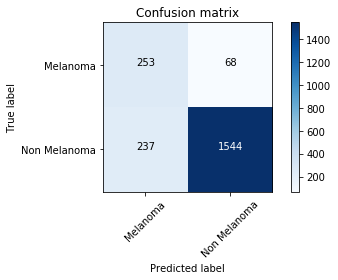

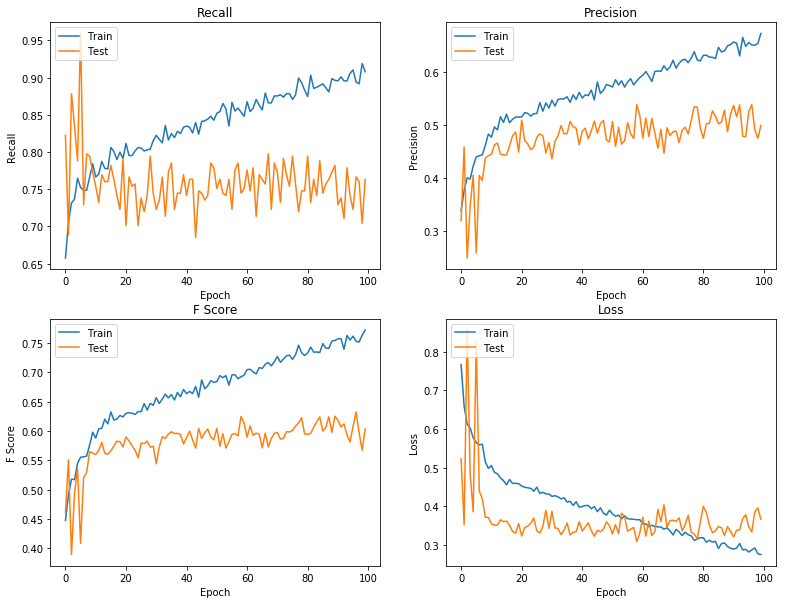

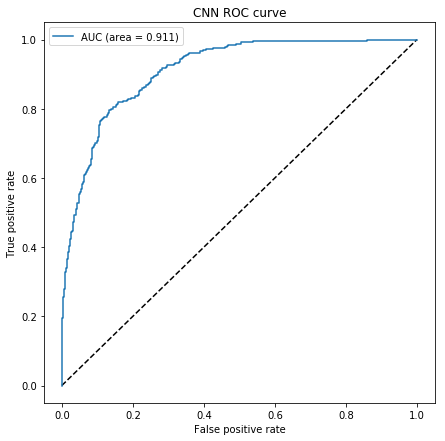

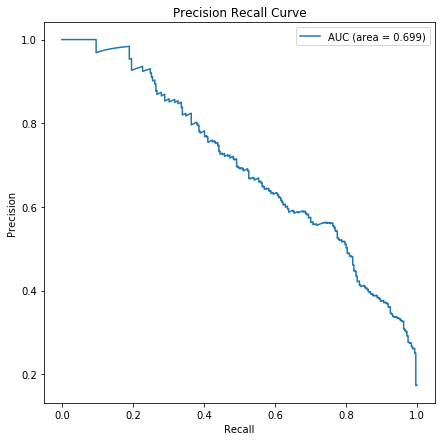

In [21]:
# reload best model for evaluation - first initialize model again
model3 = createModel(input_shape,num_classes)

#load best weights
model3.load_weights('strat.hdf5')
get_stats_thresh(model3,history3,xtest,ytest,0.5) # 0.5 threshold

### Evaluate the model above with a different threshold

Try a threshold of 0.2 ie. if there's a 20% chance or more that the leson is melanoma, classify it as melanoma. get_stats_thresh function below allows you to specify your own threshold. 

Fbeta 0.6326356984856218
              precision    recall  f1-score   support

Non Melanoma       0.97      0.74      0.84      1781
    Melanoma       0.38      0.89      0.54       321

   micro avg       0.76      0.76      0.76      2102
   macro avg       0.68      0.82      0.69      2102
weighted avg       0.88      0.76      0.80      2102

Confusion matrix


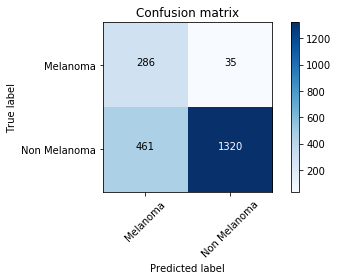

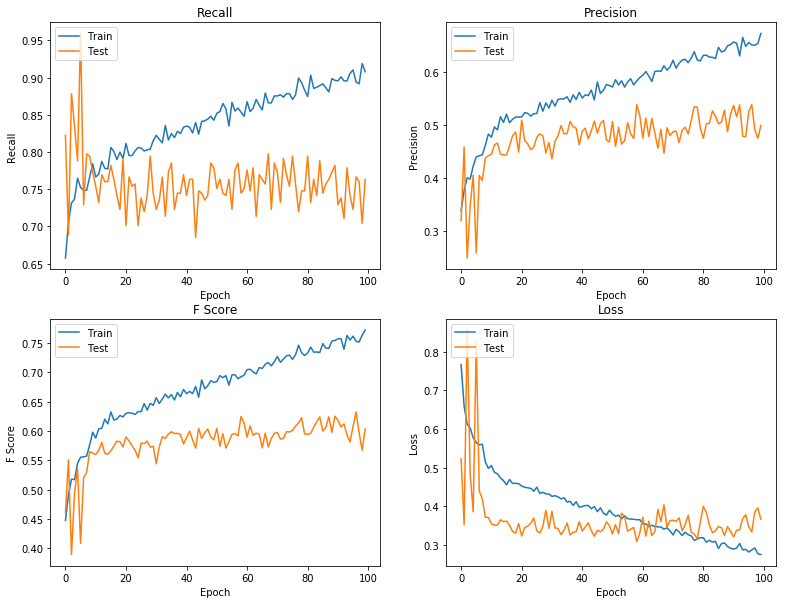

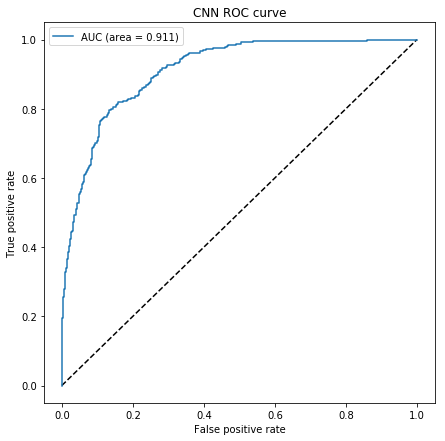

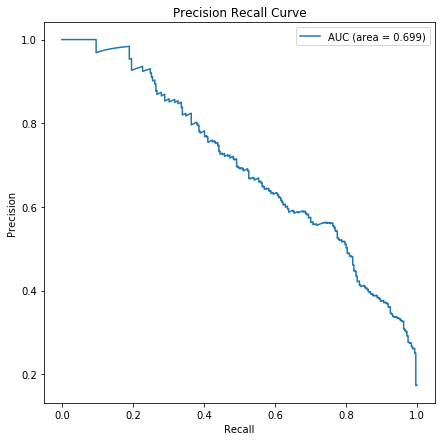

In [22]:
get_stats_thresh(model3,history3,xtest,ytest,0.2) # 0.2 threshold